In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Define paths to the metadata, image directories, and ground truth
METADATA_PATH = r"C:\Users\sarad\OneDrive - George Mason University - O365 Production\Desktop\HAM_10000\HAM10000_metadata.csv"
Image_path1 = r"C:\Users\sarad\OneDrive - George Mason University - O365 Production\Desktop\HAM_10000\HAM10000_images_part_1"
Image_path2 = r"C:\Users\sarad\OneDrive - George Mason University - O365 Production\Desktop\HAM_10000\HAM10000_images_part_2"
TEST_IMAGE_PATH = r"C:\Users\sarad\OneDrive - George Mason University - O365 Production\Desktop\HAM_10000\ISIC2018_Task3_Test_Images"
GROUND_TRUTH_PATH = r"C:\Users\sarad\OneDrive - George Mason University - O365 Production\Desktop\HAM_10000\ISIC2018_Task3_Test_GroundTruth.csv"

In [5]:
# Step 2: Load Metadata and Prepare Data
df_labels = pd.read_csv(METADATA_PATH)
print(f"Loaded metadata. Total records: {len(df_labels)}")
print(df_labels.head()) 

Loaded metadata. Total records: 10015
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [45]:
df_ground_truth = pd.read_csv(GROUND_TRUTH_PATH)
df_ground_truth['lesion_binary'] = df_ground_truth['dx'].apply(lambda x: 1 if x in ['mel', 'bcc', 'akiec'] else 0)

# Verify the ground truth DataFrame
print(f"Ground truth dataset loaded with {len(df_ground_truth)} entries.")
print(df_ground_truth.head())  

Ground truth dataset loaded with 1512 entries.
         lesion_id      image_id   dx    dx_type   age     sex localization  \
0  HAMTEST_0000000  ISIC_0034524   nv  follow_up  40.0  female         back   
1  HAMTEST_0000001  ISIC_0034525   nv      histo  70.0    male      abdomen   
2  HAMTEST_0000002  ISIC_0034526  bkl      histo  70.0    male         back   
3  HAMTEST_0000003  ISIC_0034527   nv      histo  35.0    male        trunk   
4  HAMTEST_0000004  ISIC_0034528   nv  follow_up  75.0  female        trunk   

         dataset  lesion_binary  
0  vidir_molemax              0  
1      rosendahl              0  
2      rosendahl              0  
3    vienna_dias              0  
4  vidir_molemax              0  


In [11]:
# Create binary labels (1 for malignant, 0 for benign)
df_labels['lesion_binary'] = df_labels['dx'].apply(lambda x: 1 if x in ['mel', 'bcc', 'akiec'] else 0)

In [13]:
# Add image paths from both parts and check the number of valid images
df_labels['image_path'] = df_labels['image_id'].apply(lambda x: os.path.join(Image_path1, f"{x}.jpg") if os.path.exists(os.path.join(Image_path1, f"{x}.jpg")) else os.path.join(Image_path2, f"{x}.jpg"))
df_labels = df_labels[df_labels['image_path'].apply(os.path.exists)]
print(f"Number of valid images found: {len(df_labels)}")
print(df_labels[['image_id', 'image_path', 'lesion_binary']].head())  

Number of valid images found: 10015
       image_id                                         image_path  \
0  ISIC_0027419  C:\Users\sarad\OneDrive - George Mason Univers...   
1  ISIC_0025030  C:\Users\sarad\OneDrive - George Mason Univers...   
2  ISIC_0026769  C:\Users\sarad\OneDrive - George Mason Univers...   
3  ISIC_0025661  C:\Users\sarad\OneDrive - George Mason Univers...   
4  ISIC_0031633  C:\Users\sarad\OneDrive - George Mason Univers...   

   lesion_binary  
0              0  
1              0  
2              0  
3              0  
4              0  


In [17]:
# Step 3: Split data into training and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_labels, test_size=0.2, stratify=df_labels['lesion_binary'], random_state=42)
print(f"Training set size: {len(train_df)}, Validation set size: {len(val_df)}")

Training set size: 8012, Validation set size: 2003


C:\Users\sarad\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\sarad\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [63]:
df_labels['lesion_binary'].value_counts()

lesion_binary
0    8061
1    1954
Name: count, dtype: int64

Displaying sample images from the training set...


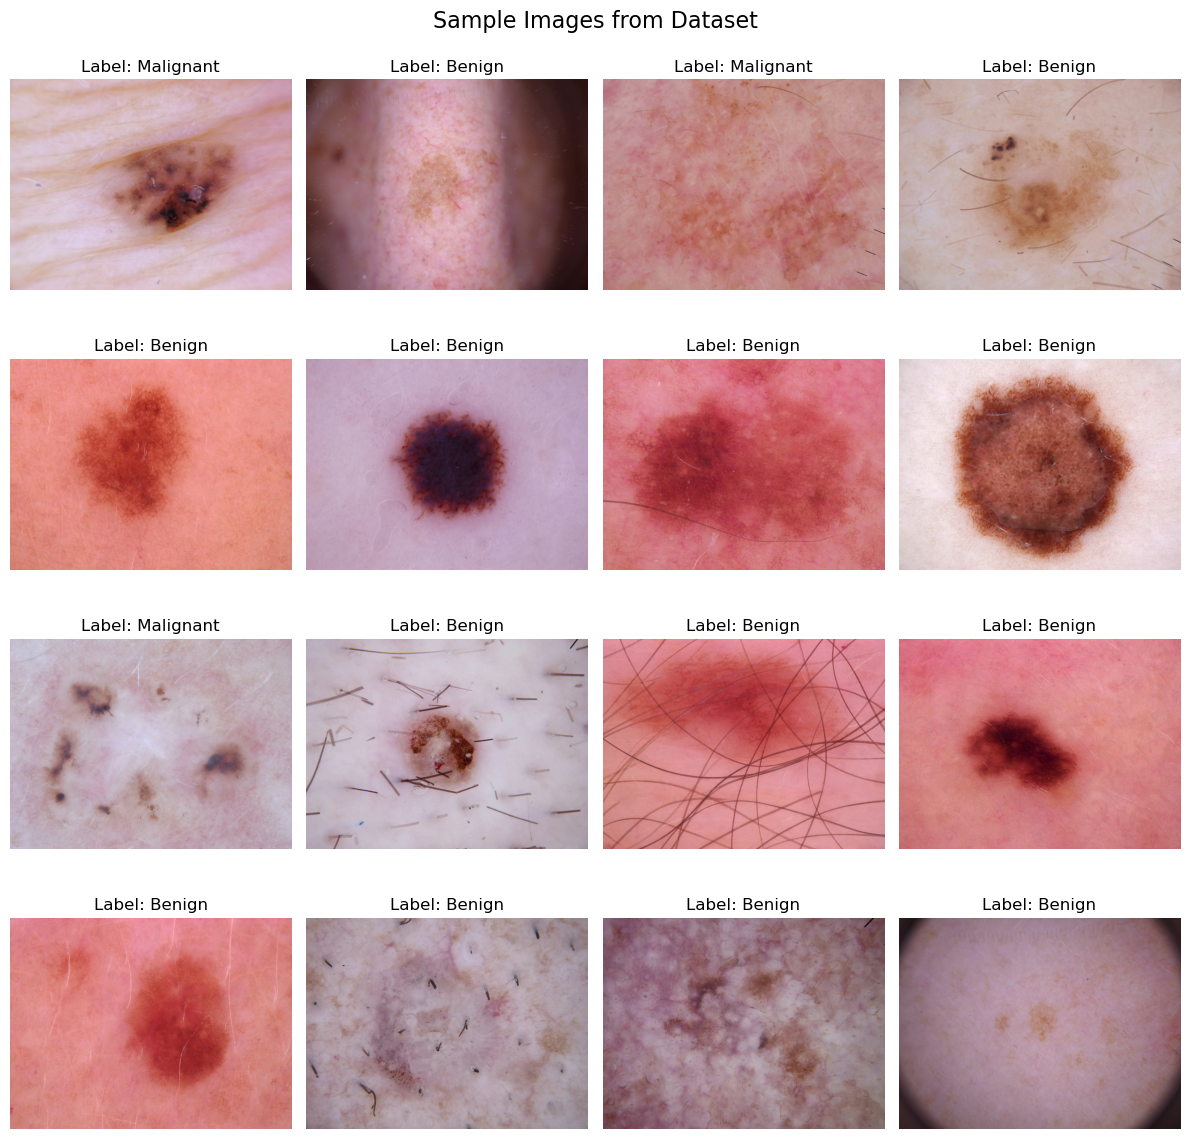

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# function to visualize a 4x4 grid of images
def plot_sample_images(dataframe, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle("Sample Images from Dataset", fontsize=16)
    # Randomly sample images from the dataframe
    sample_df = dataframe.sample(n=num_images).reset_index()
    for i, ax in enumerate(axes.flat):
        img_path = sample_df.iloc[i]['image_path']
        label_name = 'Malignant' if sample_df.iloc[i]['lesion_binary'] == 1 else 'Benign'
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(f"Label: {label_name}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
# df_labels contains the dataset after loading and preprocessing
print("Displaying sample images from the training set...")
plot_sample_images(train_df)  

In [21]:
# Step 4: Define Custom Dataset and Data Loaders
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['lesion_binary']
        if self.transform:
            image = self.transform(image)
        return image, label

In [23]:
# Step 5: Data Augmentation and Normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
# Step 6: Create datasets and dataloaders
train_dataset = SkinLesionDataset(train_df, transform=transform)
val_dataset = SkinLesionDataset(val_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train loader batches: {len(train_loader)}, Validation loader batches: {len(val_loader)}")

Train loader batches: 251, Validation loader batches: 63


In [27]:
# Step 7: Load Pretrained ResNet-34 Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Adjust for binary classification
model = model.to(device)

C:\Users\sarad\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sarad\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Step 8: Define Class Weights and Loss Function
class_weights = torch.tensor([1.0, 3.0], dtype=torch.float).to(device)  
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  

In [31]:
# Step 9: Define Optimizer and Learning Rate Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

C:\Users\sarad\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10
----------
train Loss: 0.8018 Acc: 0.7002
val Loss: 0.7074 Acc: 0.7409
Model saved with improved accuracy!
Epoch 2/10
----------
train Loss: 0.7402 Acc: 0.7258
val Loss: 0.7200 Acc: 0.7359
Epoch 3/10
----------
train Loss: 0.7123 Acc: 0.7309
val Loss: 0.7885 Acc: 0.7444
Model saved with improved accuracy!
Epoch 4/10
----------
train Loss: 0.7366 Acc: 0.7242
val Loss: 0.7096 Acc: 0.7449
Model saved with improved accuracy!
Epoch 5/10
----------
train Loss: 0.6933 Acc: 0.7257
val Loss: 0.7233 Acc: 0.7049
Epoch 6/10
----------
train Loss: 0.6725 Acc: 0.7239
val Loss: 0.6668 Acc: 0.7314
Epoch 7/10
----------
train Loss: 0.6616 Acc: 0.7339
val Loss: 0.6492 Acc: 0.7499
Model saved with improved accuracy!
Epoch 8/10
----------
train Loss: 0.6506 Acc: 0.7469
val Loss: 0.6537 Acc: 0.7514
Model saved with improved accuracy!
Epoch 9/10
----------
train Loss: 0.6501 Acc: 0.7411
val Loss: 0.6442 Acc: 0.7728
Model saved with improved accuracy!
Epoch 10/10
----------
train Loss: 0.6501 Acc:

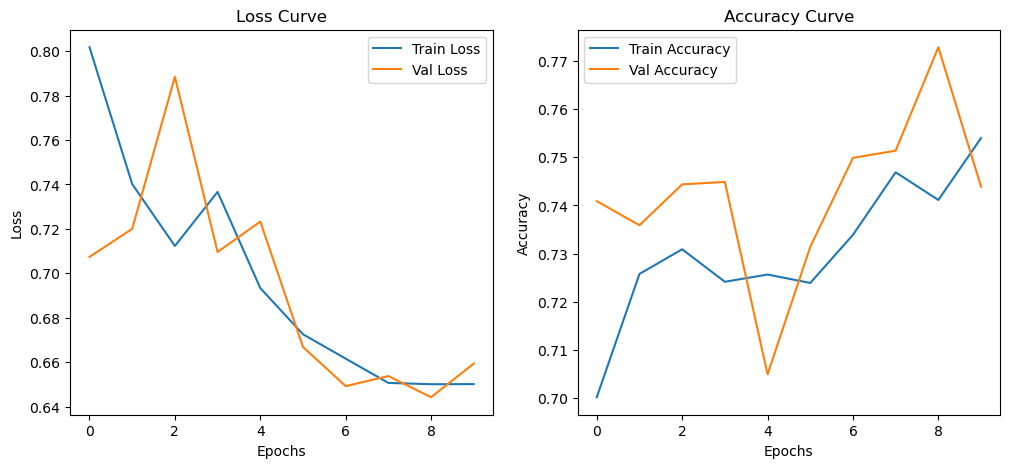

In [35]:
# Step 10: Training Function 
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    best_accuracy = 0.0
    train_loss, val_loss = [], []  # Initialize lists to store losses
    train_acc, val_acc = [], []  # Initialize lists to store accuracies

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted_train = (torch.sigmoid(outputs) >= 0.5).float()
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                predicted_val = (torch.sigmoid(outputs) >= 0.5).float()
                correct_val += (predicted_val == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_acc = correct_val / total_val
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(f'train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Learning rate scheduler step
        scheduler.step(epoch_val_loss)

        # Model saving
        if epoch_val_acc > best_accuracy:
            best_accuracy = epoch_val_acc
            torch.save(model.state_dict(), "best_resnet34.pth")
            print("Model saved with improved accuracy!")

    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.show()

# Step 11: Train the Model for 10 Epochs
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)

In [47]:
import os

# Define test_images by listing all .jpg files in the TEST_IMAGE_PATH directory
test_images = [os.path.join(TEST_IMAGE_PATH, img) for img in os.listdir(TEST_IMAGE_PATH) if img.endswith('.jpg')]

# Check how many test images are found (this prints the first 5 image paths as a check)
print(f"Total test images found: {len(test_images)}")
print(f"First 5 test images: {test_images[:5]}")


Total test images found: 1511
First 5 test images: ['C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034524.jpg', 'C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034525.jpg', 'C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034526.jpg', 'C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034527.jpg', 'C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034528.jpg']


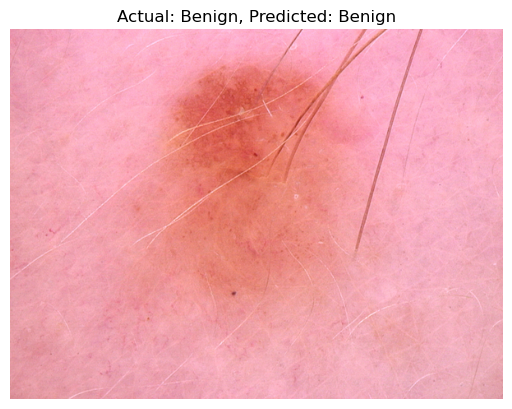

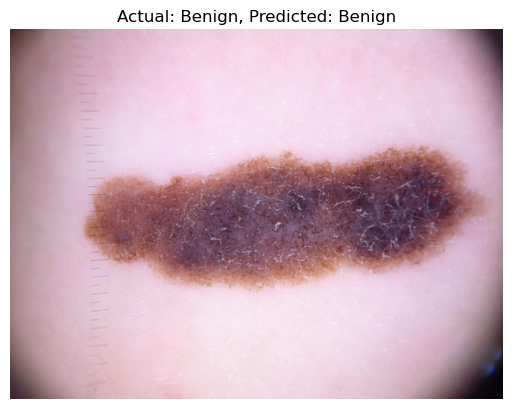

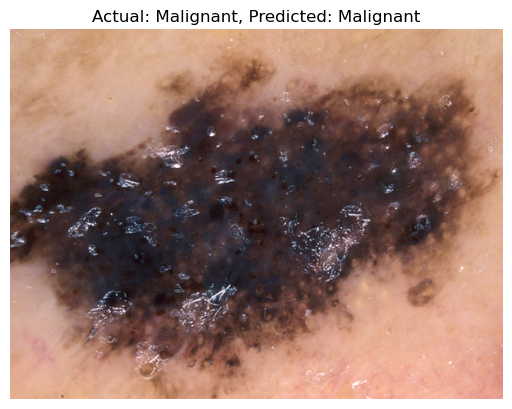

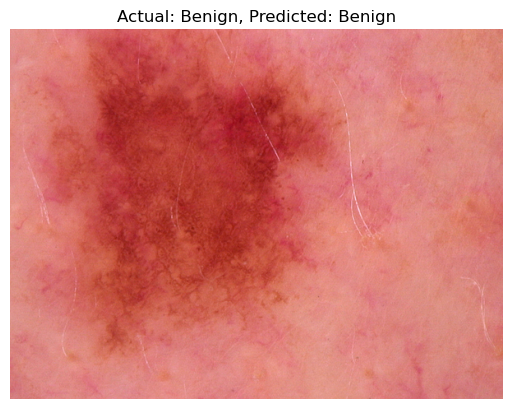

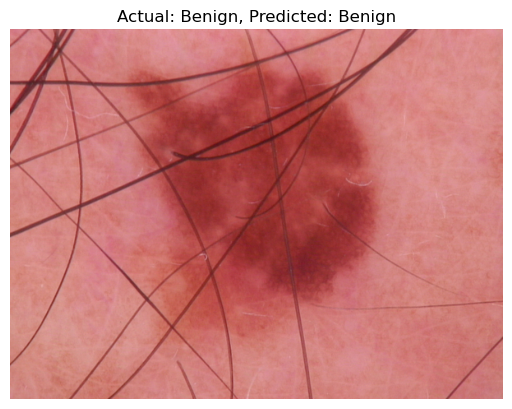

In [55]:
# Function to predict on multiple images and display actual and predicted labels
def predict_multiple_images(model, image_paths, ground_truth_df, transform):
    model.eval()  # Set the model to evaluation mode
    for image_path in image_paths:
        # Get the image ID from the file path
        image_id = os.path.basename(image_path).replace(".jpg", "")
        # Find the actual label in the ground truth dataframe
        actual_label_row = ground_truth_df[ground_truth_df['image_id'] == image_id]
        if actual_label_row.empty:
            print(f"No ground truth label found for {image_id}. Skipping this image.")
            continue
        # Load the image and apply transforms
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        # Get the actual label
        actual_label = actual_label_row['lesion_binary'].values[0]
        actual_label_text = 'Malignant' if actual_label == 1 else 'Benign'
        
        # Make a prediction
        with torch.no_grad():
            output = model(image_tensor)
            prob = torch.sigmoid(output).item()
            predicted_label = 1 if prob >= 0.5 else 0
            predicted_label_text = 'Malignant' if predicted_label == 1 else 'Benign'
        
        # Display the image with actual and predicted labels
        plt.imshow(np.array(image))
        plt.title(f"Actual: {actual_label_text}, Predicted: {predicted_label_text}")
        plt.axis('off')
        plt.show()
image_paths = [
    "C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034551.jpg",
    "C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034599.jpg",
    "C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034638.jpg",
    "C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034689.jpg",
    "C:\\Users\\sarad\\OneDrive - George Mason University - O365 Production\\Desktop\HAM_10000\\ISIC2018_Task3_Test_Images\\ISIC_0034707.jpg"]
predict_multiple_images(model, image_paths, df_ground_truth, transform)

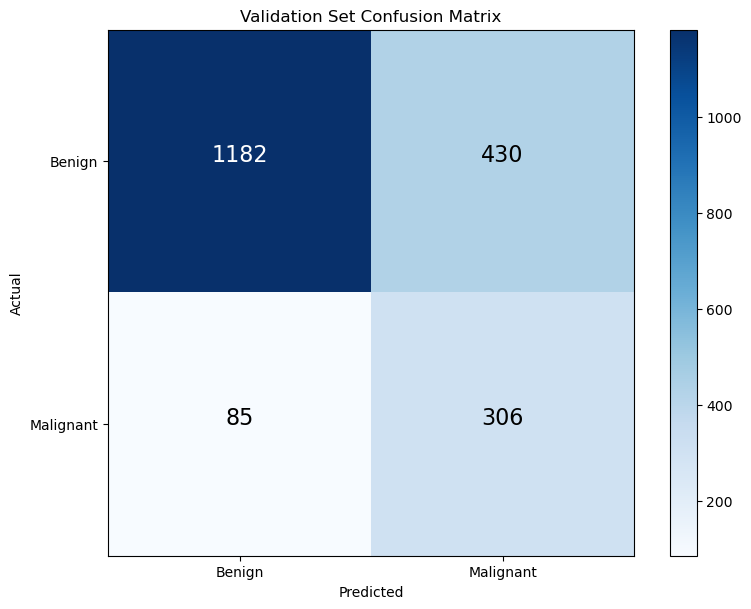

Validation Set Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.73      0.82      1612
   Malignant       0.42      0.78      0.54       391

    accuracy                           0.74      2003
   macro avg       0.67      0.76      0.68      2003
weighted avg       0.83      0.74      0.77      2003

Validation Set ROC AUC Score: 0.8311


In [89]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_probs_val = np.array(y_probs_val)
y_pred_val = (y_probs_val > 0.5).astype(int)  
# Generating the confusion matrix
cm_val = confusion_matrix(y_true_val, y_pred_val)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Validation Set Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(['Benign', 'Malignant']))
plt.xticks(tick_marks, ['Benign', 'Malignant'])
plt.yticks(tick_marks, ['Benign', 'Malignant'])

thresh = cm_val.max() / 2
for i, j in np.ndindex(cm_val.shape):
    plt.text(j, i, format(cm_val[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_val[i, j] > thresh else "black",
             fontsize=16)

plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Print the classification report
report = classification_report(y_true_val, y_pred_val, target_names=['Benign', 'Malignant'])
print("Validation Set Classification Report:")
print(report)
# Calculate and print the AUC-ROC score
roc_auc = roc_auc_score(y_true_val, y_probs_val) 
print(f'Validation Set ROC AUC Score: {roc_auc:.4f}')

Test Set Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.69      0.80      1204
   Malignant       0.41      0.86      0.56       307

    accuracy                           0.72      1511
   macro avg       0.68      0.77      0.68      1511
weighted avg       0.84      0.72      0.75      1511



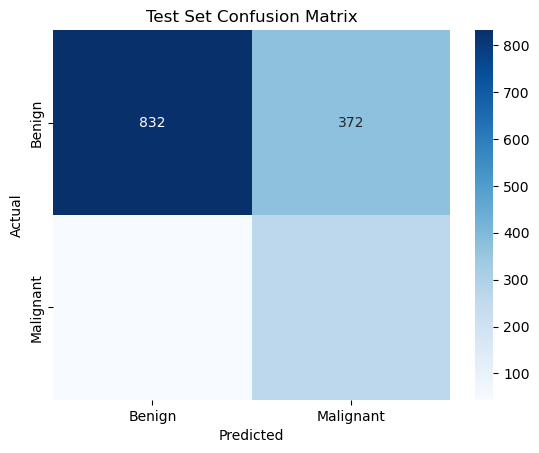

Test Set ROC AUC Score: 0.8347


In [91]:
import os
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store true labels, predicted labels, and probabilities
y_true_test = []
y_pred_test = []
y_probs_test = []
# Process the test images and compare with ground truth
with torch.no_grad():
    for image_path in test_images:
        image_id = os.path.basename(image_path).replace(".jpg", "")
        actual_label_row = df_ground_truth[df_ground_truth['image_id'] == image_id]
        if actual_label_row.empty:
            print(f"No ground truth label found for {image_id}. Skipping this image.")
            continue
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        actual_label = actual_label_row['lesion_binary'].values[0]
        
        # Get prediction from the model
        output = model(image_tensor)
        prob = torch.sigmoid(output).item()
        predicted_label = 1 if prob >= 0.5 else 0
        y_true_test.append(actual_label)
        y_pred_test.append(predicted_label)
        y_probs_test.append(prob)
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
y_probs_test = np.array(y_probs_test)

# Generate the classification report for the test set
print("Test Set Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=['Benign', 'Malignant']))

# Generate and display the confusion matrix for the test set
cm_test = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate and print the AUC-ROC score for the test set
roc_auc_test = roc_auc_score(y_true_test, y_probs_test)
print(f'Test Set ROC AUC Score: {roc_auc_test:.4f}')